# Walidacja projekt 2
### Wojciech Grabias, Wiktor Wierzchowski

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings
from sklearn.cluster import OPTICS
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from mpl_toolkits import mplot3d
import matplotlib.colors as mcolors
warnings.filterwarnings('ignore')

### Preprocessing

In [3]:
class Data_Processor:

    def __init__(self):
        self.train_data = None
        self.test_data = None
        self.val_data = None

    def load_split(self, file_path):
        df = pd.read_csv(file_path)
        train_data, val_data = train_test_split(df, test_size=0.3, random_state=42)
        train_data, test_data = train_test_split(train_data, test_size=0.3, random_state=42)
        train_data.reset_index(inplace=True, drop=True)
        test_data.reset_index(inplace=True, drop=True)
        val_data.reset_index(inplace=True, drop=True)
        train_data = train_data.drop(['id'], axis=1)
        test_data = test_data.drop(['id'], axis=1)
        val_data = val_data.drop(['id'], axis=1)
        self.train_data = train_data
        self.test_data = test_data
        self.val_data = val_data

    def normalize_data(self):
        normalize = MinMaxScaler()
        norm_train = normalize.fit_transform(self.train_data)
        norm_test = normalize.transform(self.test_data)
        norm_val = normalize.transform(self.val_data)
        self.train_data = pd.DataFrame(norm_train, columns=self.train_data.columns)
        self.test_data = pd.DataFrame(norm_test, columns=self.test_data.columns)
        self.val_data = pd.DataFrame(norm_val, columns=self.val_data.columns)

    def get_train_data(self):
        return self.train_data
    
    def get_test_data(self):
        return self.test_data
    
    def get_val_data(self):
        return self.val_data

In [4]:
# Nie było za dużo preprocessingu. Wszystko jest w porządku.

In [5]:
dp = Data_Processor()
dp.load_split('heart_disease_patients.csv')
dp.normalize_data()
X_train = dp.get_train_data()
X_test = dp.get_test_data()
X_val = dp.get_val_data()

### Wybrany model

In [6]:
# Podoba nam się pomysł z użyciem zdolności OPTICS do wykrywania outlierów w kontekście medycznym.
# Dodatkowy wskaźnik o nietypowej sytuacji dla lekarzy.

In [7]:
model = OPTICS(min_samples=10, metric='l2', p=4)
pred = model.fit_predict(X_train)

In [8]:
#t-SNE
def t_sne(X, perplexity, pred):
    tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=perplexity).fit_transform(X)
    df1 = pd.DataFrame()
    df1['y'] = pred
    df1["comp-1"] = tsne[:,0]
    df1["comp-2"] = tsne[:,1]
    sns.scatterplot(x="comp-1", y="comp-2", hue=df1.y.tolist(),
            palette=sns.color_palette("hls", len(df1.y.unique())),
            data=df1)
#PCA
def pca_plt(X, pred, dim=2):
    pca = PCA(n_components=dim).fit_transform(X)
    df1 = pd.DataFrame()
    
    df1['y'] = pred
    for i in range(dim):
        df1[f"comp-{i}"] = pca[:,i]

    if dim == 2:
        sns.scatterplot(x="comp-0", y="comp-1", hue=df1.y.tolist(),
                palette=sns.color_palette("hls", len(df1.y.unique())),
                data=df1)

    elif dim == 3:
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        colors = ['red', 'orange', 'yellow', 'green', 'teal', 'skyblue', 'navy']
        cmap_custom = mcolors.ListedColormap(colors)
        ax.scatter3D(df1['comp-0'], df1['comp-1'], df1['comp-2'], c=pred, cmap=cmap_custom)
        ax.view_init(azim=45, elev=30)

In [9]:
# Przy wyborze palety sns proponujemy zamiane hard coded wartości 10 na liczbę unikalnych etykiet len(df1.y.unique()).

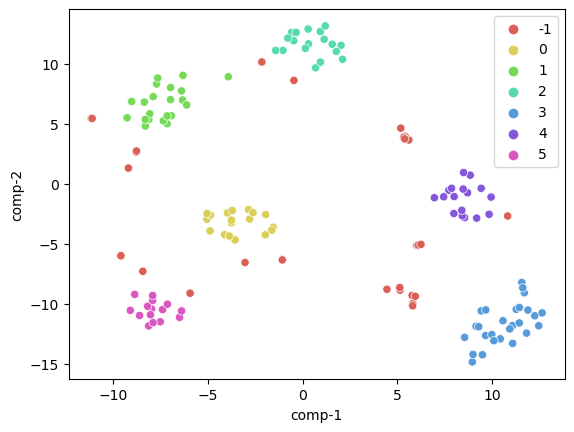

In [10]:
t_sne(X_train, 20, pred)

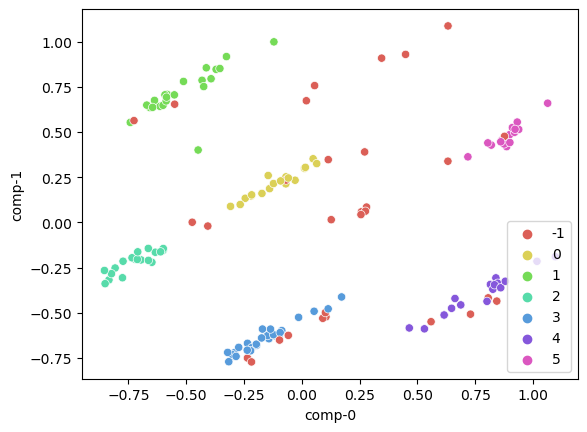

In [11]:
pca_plt(X_train, pred)

In [12]:
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X_train, pred)

pred_test = knn_classifier.predict(X_test)

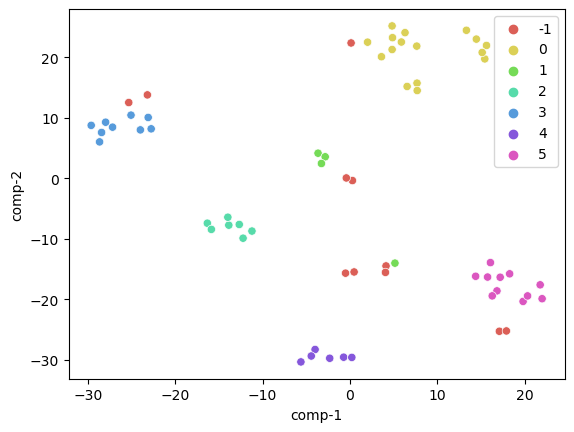

In [13]:
t_sne(X_test, 5, pred_test)

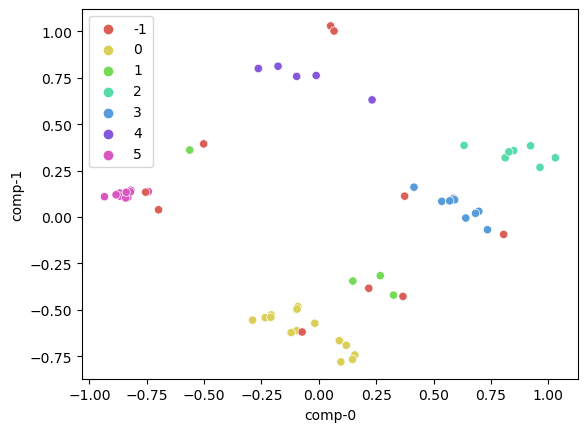

In [14]:
pca_plt(X_test, pred_test)

In [15]:
# Klastry formują się w miarę zadowalająco. Można dodać jeszcze spojrzenie 3-wymiarowe.

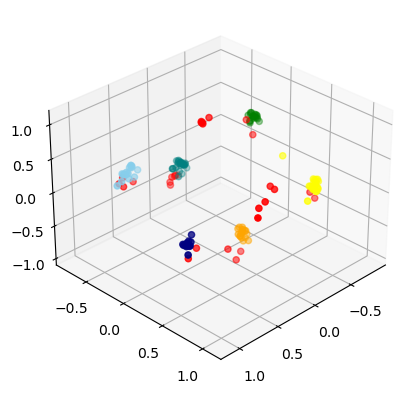

In [16]:
pca_plt(X_train, pred, 3)

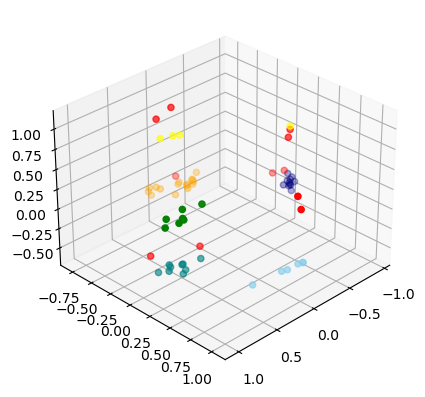

In [17]:
pca_plt(X_test, pred_test, dim=3)

In [18]:
# Poniżej wykonujemy predykcję na zbiorze walidacyjnym. Widzimy, że model przyporządkował klastry i wielu 
# miejscach zrobił to zadowalająco. Pewne obserwacje zakwalifikowane jako outliery tworzą jednak zgrupowania, które 
# można by potraktować jako pełnoprawne klastry.

In [19]:
pred_val = knn_classifier.predict(X_val)

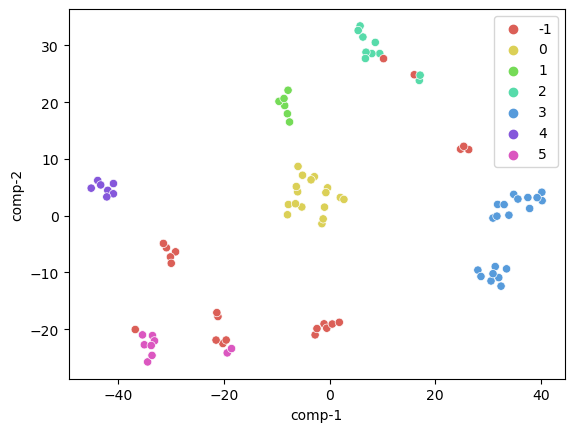

In [20]:
t_sne(X_val, 5, pred_val)

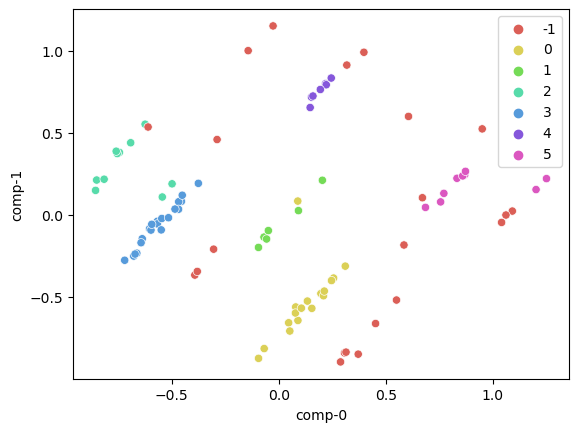

In [21]:
pca_plt(X_val, pred_val)

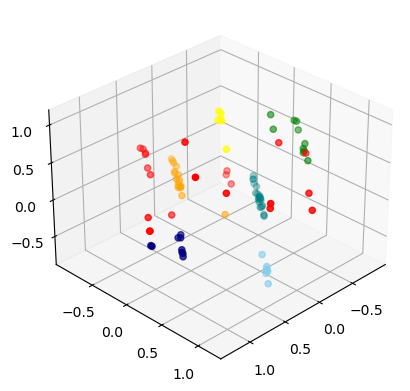

In [22]:
pca_plt(X_val, pred_val, dim=3)

### Interpretacja

In [23]:
# Do interpretacji klastrów zasugerowaliśmy drzewo losowe o następujących parametrach:
# {'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 100}

In [24]:
forest = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': range(5, 11),
    'min_samples_split': range(2, 11)
}
grid_search = GridSearchCV(forest, param_grid, cv=5)
grid_search.fit(X_train, pred)
best_params = grid_search.best_params_
best_params

{'max_depth': 6, 'min_samples_split': 5, 'n_estimators': 100}

In [25]:
feature_importances = pd.DataFrame({'Feature': X_train.columns,
                                   'Importance': grid_search.best_estimator_.feature_importances_})
feature_importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)

,Feature,Importance
0,sex,0.206687
1,restecg,0.198051
2,exang,0.151013
3,fbs,0.118236
4,thalach,0.070576
5,age,0.058793
6,oldpeak,0.053307
7,trestbps,0.043596
8,cp,0.039343
9,chol,0.037320


In [26]:
def plots_clusters(cluster_num):
    sns.set(style="darkgrid")
    f, axes = plt.subplots(nrows=2, ncols=3)

    i = 0
    x, y = i//3, i%3 
    sns.histplot(x='thalach', data=X_train.loc[pred == cluster_num], ax=axes[x, y])
    axes[x,y].set_title('thalach')
    axes[x,y].set_xlabel('')
    axes[x,y].set_ylabel('')
    i += 1
        

    for column in ['sex', 'fbs', 'restecg', 'exang']:
        x, y = i//3, i%3 
        sns.countplot(x=column, data=X_train.loc[pred == cluster_num], ax=axes[x, y])
        axes[x,y].set_title(column)
        axes[x,y].set_xlabel('')
        axes[x,y].set_ylabel('')
        i += 1

    f.delaxes(axes[i//3, i%3])
    f.suptitle(f'Cluster {cluster_num}')

    plt.tight_layout()

In [27]:
# Następnie zespół walidacji zbadał rozkład cech w wyznaczonych klastrach. Wszystko poprawnie.

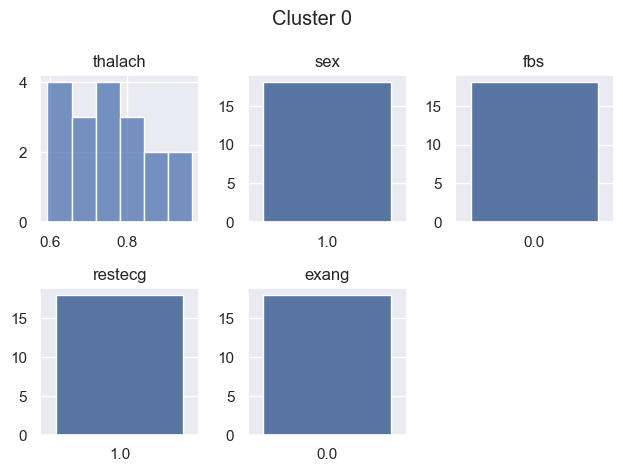

In [28]:
plots_clusters(0)

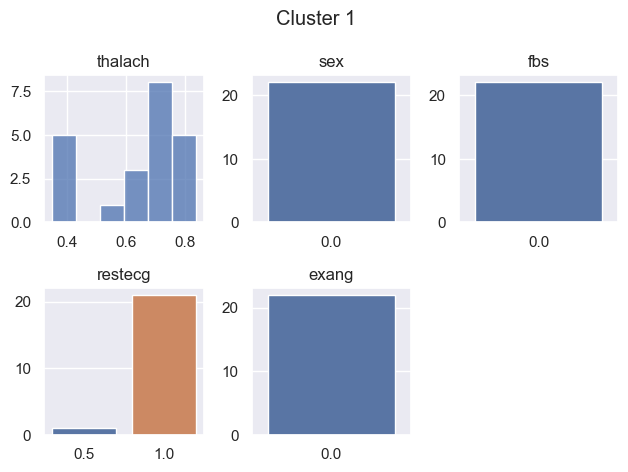

In [29]:
plots_clusters(1)

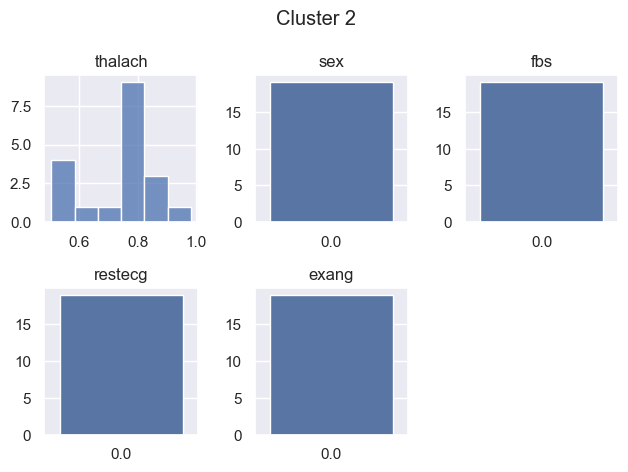

In [30]:
plots_clusters(2)

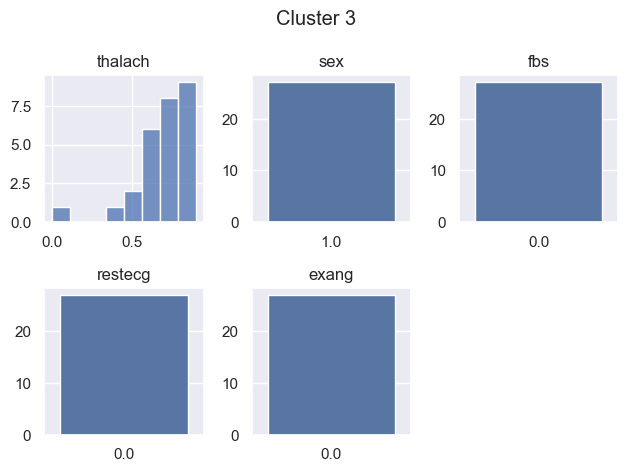

In [31]:
plots_clusters(3)

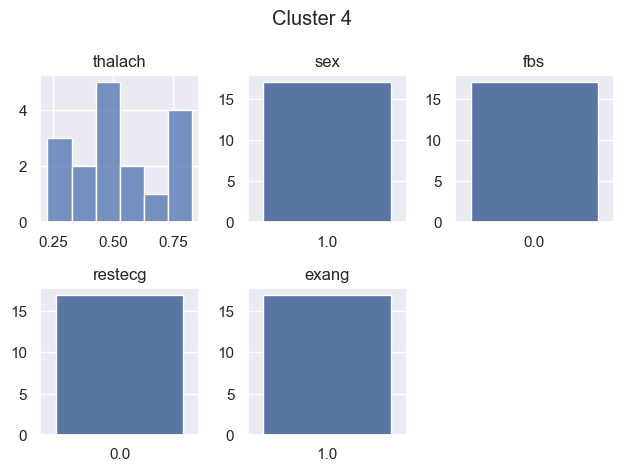

In [32]:
plots_clusters(4)

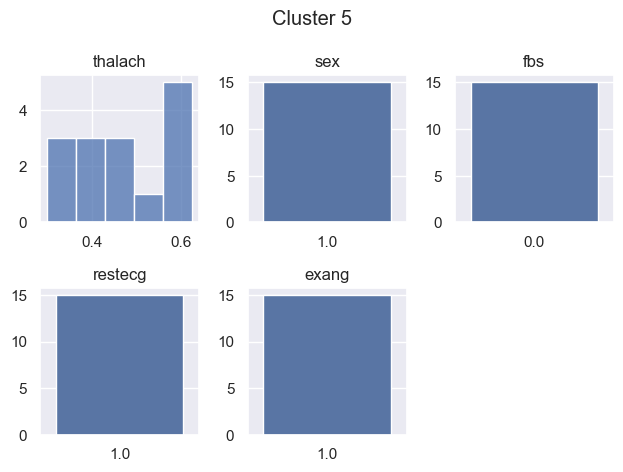

In [33]:
plots_clusters(5)

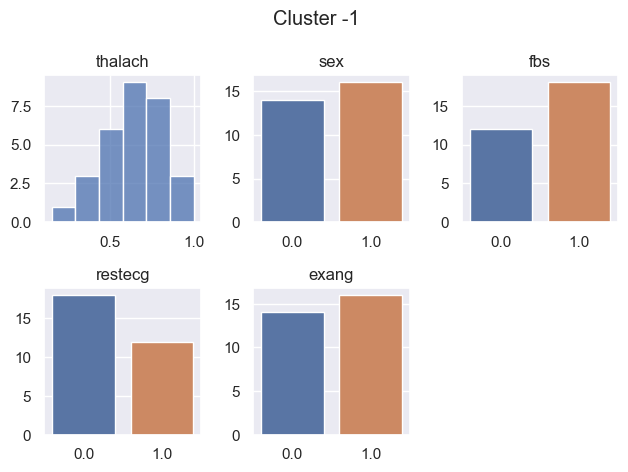

In [34]:
plots_clusters(-1)

In [ ]:
# Dalej następuje odczyt rozkładu i słowny opis charakteryzujący klaster. Uważamy, że nie jest to najlepszy sposób
# rozróżniania klastrów ale należy to zaakceptować. Zdajemy sobie sprawę z ograniczeń interpretowania wyników ze 
# względu na brak wykształcenia medycznego. 

In [47]:
# Ogólna wrażenie jest bardzo dobre. Chcieliśmy szczególnie pochwalić estetyke i czytelność kodu.